##### OBJETIVO: Analizar las predicciones mensuales obtenidas de los mapas diarios considerando los modelos con/sin AOD
- Version 02
- Hacemos los sitios por separados por el modelo
- Aunque se podria hacer un paste solo con el nombre.
- Por ahora lo dejamos asi

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("libreria ok")

libreria ok


Problema como todos los modelos son distintos lo debeira hacer manual 
pero genero un diccionario para setearlos de una vez, al principio de la notebook

In [ ]:
#Lo hacemos asi porque todos son distintos entonces lo ponemos una vez y ya esta
STATIONS = {
    "SP": {
        "file_AOD": "SP_merge_01-XGB-CV-M1-200525-SP.csv",
        "file_sAOD": "SP_merge_02-XGB-CV-1-210525-sAOD-SP.csv",
        "colors": {
            "Mediciones": "black",
            "AOD": "#a1d99b",
            "sAOD": "#41ab5d",
        }
    },
    "CH": {
        "file_AOD": "CH_merge_01-XGB-CV-M1-190625-CH.csv",
        "file_sAOD": "CH_merge_02-XGB-CV-M1-230625-sAOD-CH.csv",
        "mean_col": "Registros.completos",
        "colors": {
            "Mediciones": "black",
            "AOD": "#feb24c",
            "sAOD": "#fc4e2a",
        }
    },
    "BA": {
        "file_AOD": "BA_merge_01-ET-CV-M1-170625-BA.csv",
        "file_sAOD": "BA_merge_02-ET-CV-M1-230625-sAOD-BA.csv",
        "colors": {
            "Mediciones": "black",
            "AOD": "#fb6a4a",
            "sAOD": "#99000d",
        }
    },
    "MD": {
        "file_AOD": "MD_merge_01-ET-CV-M1-260525-MD.csv",
        "file_sAOD": "MD_merge_01-ET-CV-M1-270525-sAOD-MD.csv",
        "colors": {
            "Mediciones": "black",
            "AOD": "#9ecae1",
            "sAOD": "#2171b5",
        }
    },
    "MX": {
        "file_AOD": "MX_merge_01-XGB-CV-M1-290525-MX.csv",
        "file_sAOD": "MX_merge_02-XGB-CV-M1-230625-sAOD-MX.csv",
        "colors": {
            "Mediciones": "black",
            "AOD": "#807dba",
            "sAOD": "#810f7c",
        }
    },
}


In [ ]:
#Meses en esp
MONTH_LABELS = ["Ene","Feb","Mar","Abr","May","Jun",
                "Jul","Ago","Sep","Oct","Nov","Dic"]

#Funcion para cargar la info de cada centro urbano segun el diccionario anterior
def load_and_process(estacion, config, base_path):
    path = Path(base_path) / estacion / "resultados/merge_Prediccion_Real"
    #Se comparar las predicciones con/sin AOD
    df_AOD = pd.read_csv(path / config["file_AOD"], encoding="latin1")
    df_sAOD = pd.read_csv(path / config["file_sAOD"], encoding="latin1")
    #Configurar la columna de innteres
    mean_col = config.get("mean_col", "mean")

    for df in [df_AOD, df_sAOD]:
        df["date"] = pd.to_datetime(df["date"])
        df["month"] = df["date"].dt.month
        df = df[df["valor_raster"] > 0]
    
    #Solo compramos la info del año 2024
    df_AOD = df_AOD[df_AOD["date"].dt.year == 2024]
    df_sAOD = df_sAOD[df_sAOD["date"].dt.year == 2024]

    #Hacemos promedios mensuales porque la info esta diaria para ambos arrchivos
    monthly_AOD = df_AOD.groupby("month").agg(
        mean_pm25_AOD=(mean_col, "mean"),
        mean_valor_raster_AOD=("valor_raster", "mean")
    ).reset_index()

    monthly_sAOD = df_sAOD.groupby("month").agg(
        mean_pm25_sAOD=(mean_col, "mean"),
        mean_valor_raster_sAOD=("valor_raster", "mean")
    ).reset_index()

    #Calculamos esto para hacer +/- 1sd
    stats = df_sAOD.groupby("month")[mean_col].agg(["mean", "std"]).reset_index()
    stats["ymin"] = stats["mean"] - stats["std"]
    stats["ymax"] = stats["mean"] + stats["std"]
    
    #Unimos en un mismo dataframe
    merged = monthly_sAOD.merge(monthly_AOD, on="month")
    long = merged.melt(
        id_vars="month",
        value_vars=[
            "mean_pm25_sAOD",
            "mean_valor_raster_AOD",
            "mean_valor_raster_sAOD"
        ],
        var_name="variable",
        value_name="valor"
    )

    #Tipo de varaible
    long["month"] = pd.Categorical(
        long["month"],
        categories=range(1, 13),
        ordered=True
    )
    # stats["month"] = long["month"].cat.categories

    # asegurar orden de meses SOLO en los que existen
    #Porque para BA solo son algunos
    stats["month"] = pd.Categorical(
    stats["month"],
    categories=range(1, 13),
    ordered=True
)


    return long, stats


In [22]:
#Funcion para hacer el plot correspondiente a la variabildiad mensual para cada centro urbano
def plot_monthly(long_df, stats_df, colors, title=None):
    plt.figure(figsize=(8, 4))

    plt.fill_between(
        stats_df["month"],
        stats_df["ymin"],
        stats_df["ymax"],
        color="grey",
        alpha=0.2
    )

    plt.plot(stats_df["month"], stats_df["ymin"], "--", color="grey")
    plt.plot(stats_df["month"], stats_df["ymax"], "--", color="grey")

    mapping = {
        "mean_pm25_sAOD": "Mediciones",
        "mean_valor_raster_AOD": "AOD",
        "mean_valor_raster_sAOD": "sAOD"
    }

    for var, label in mapping.items():
        subset = long_df[long_df["variable"] == var]
        plt.plot(
            subset["month"],
            subset["valor"],
            marker="o",
            label=label,
            color=colors[label]
        )

    plt.title(title)
    plt.ylim(0, 80)
    plt.xticks(range(1, 13), MONTH_LABELS)
    plt.legend(frameon=True)
    sns.despine()
    plt.tight_layout()
    plt.show()


C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_3176\359148944.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sAOD = pd.read_csv(path / config["file_sAOD"], encoding="latin1")


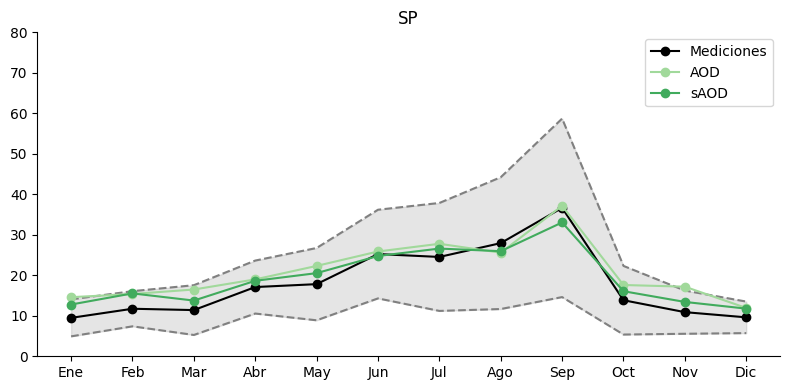

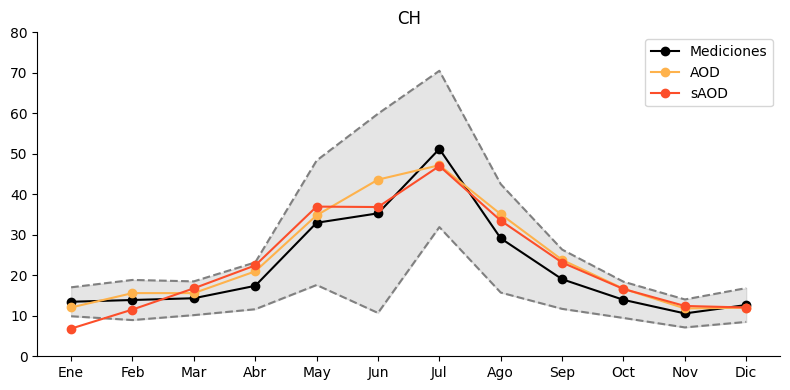

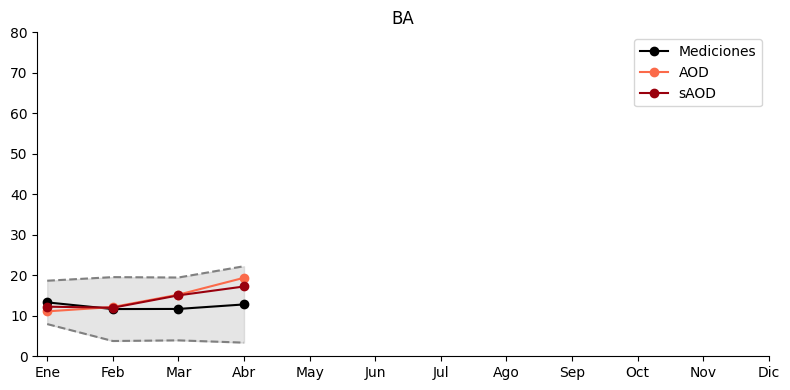

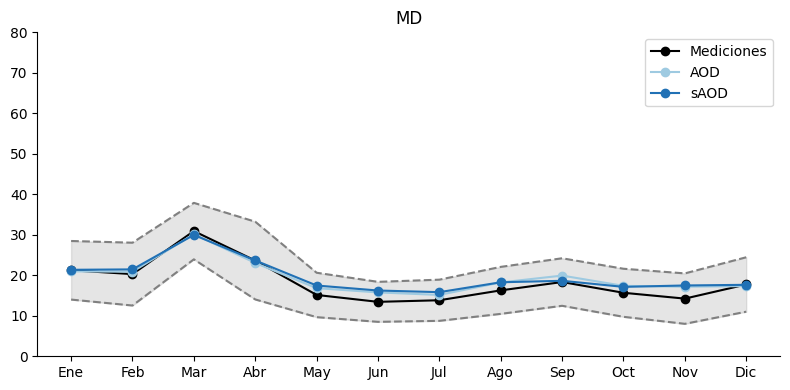

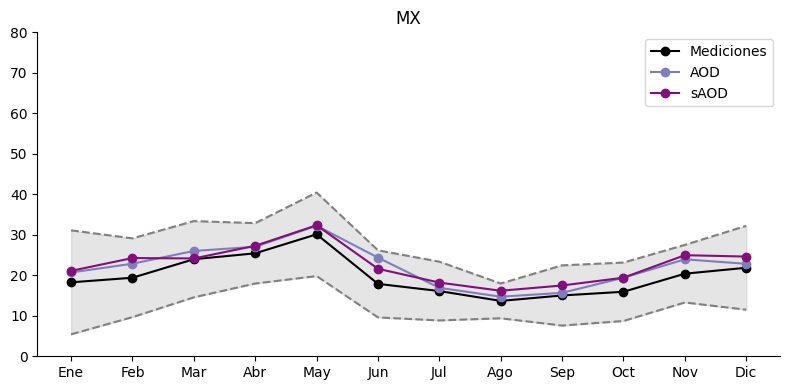

In [23]:
#Hacemos los plots para cada uno de los centros urbanos cin las funciones anteriores
BASE_PATH = "D:/Josefina/Proyectos/Tesis"

for est, cfg in STATIONS.items():
    long_df, stats_df = load_and_process(est, cfg, BASE_PATH)
    plot_monthly(long_df, stats_df, cfg["colors"], title=est)
